In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install librosa

/tmp/ipykernel_30/3942819308.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Input spectrogram shape: (80, 11254)
Converted spectrogram shape: (80, 11256)
Converted spectrogram values (sample): [[-63.446102 -68.194626 -72.572876 -75.98076  -79.33463 ]
 [-62.100353 -67.18235  -72.282166 -75.047585 -78.71993 ]
 [-57.20143  -63.008007 -68.3333   -71.50999  -75.62395 ]
 [-54.553898 -60.59569  -66.25598  -70.241554 -74.2901  ]
 [-58.514236 -65.17725  -70.08216  -73.738304 -76.59108 ]]
Audio signal shape: (2881280,), Sampling rate: 16000
Converted audio saved to: /kaggle/working/arijit_to_kishore_epoch190.wav


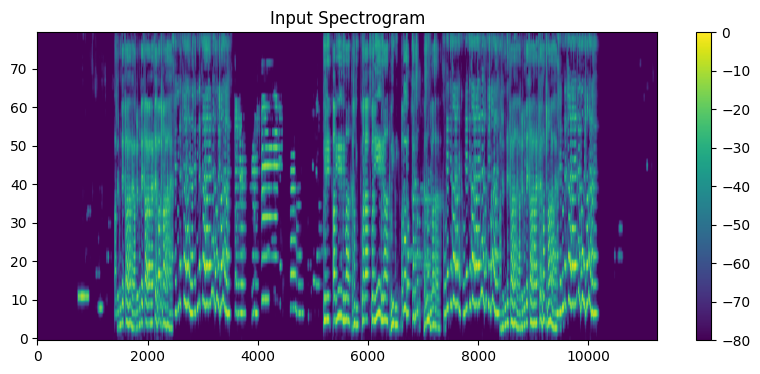

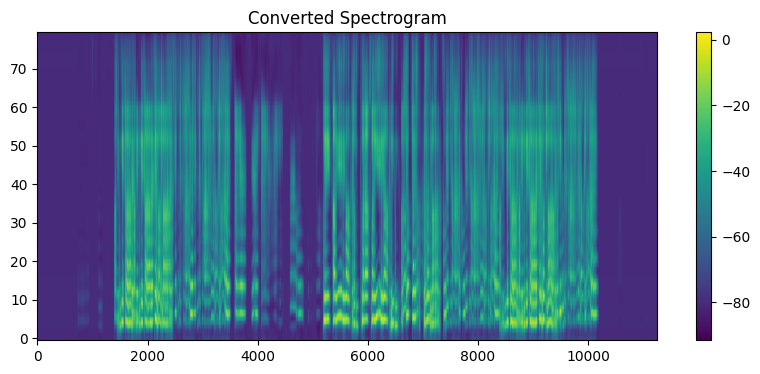

In [2]:
import torch
import numpy as np
import librosa
import os
from tqdm import tqdm
import torch.nn as nn
import soundfile as sf
import matplotlib.pyplot as plt

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=256, num_residual_blocks=6):
        super(Generator, self).__init__()
        layers = [
            nn.Conv1d(input_dim, hidden_dim, kernel_size=15, padding=7),
            nn.InstanceNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        for _ in range(2):
            layers.append(
                nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=5, stride=2, padding=2)
            )
            layers.append(nn.InstanceNorm1d(hidden_dim * 2))
            layers.append(nn.ReLU(inplace=True))
            hidden_dim *= 2

        # Residual blocks
        for _ in range(num_residual_blocks):
            layers.append(ResidualBlock(hidden_dim))

        # Upsampling
        for _ in range(2):
            layers.append(
                nn.ConvTranspose1d(hidden_dim, hidden_dim // 2, kernel_size=5, stride=2, padding=2, output_padding=1)
            )
            layers.append(nn.InstanceNorm1d(hidden_dim // 2))
            layers.append(nn.ReLU(inplace=True))
            hidden_dim //= 2

        layers.append(nn.Conv1d(hidden_dim, input_dim, kernel_size=15, padding=7))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm1d(dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm1d(dim)
        )

    def forward(self, x):
        return x + self.block(x)
        
# Utility function to pad or trim tensors to a consistent length
def pad_or_trim_tensor(tensor, target_length):
    # Handle 4D tensor from some spectrogram formats
    if tensor.ndim == 4:
        # Squeeze out unnecessary dimensions
        tensor = tensor.squeeze(0)

    # If tensor is already a PyTorch tensor, convert to NumPy if needed
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.numpy()

    # Ensure tensor is of shape (80, time_steps)
    if tensor.ndim == 3:
        if tensor.shape[0] == 1:
            tensor = tensor.squeeze(0)
        elif tensor.shape[2] == 80:
            tensor = tensor.transpose(0, 2).squeeze(0)
    elif tensor.ndim == 2:
        # If shape is (time_steps, 80)
        if tensor.shape[1] == 80:
            tensor = tensor.T
    # Ensure shape is (80, time_steps)
    assert tensor.shape[0] == 80, f"Unexpected tensor shape: {tensor.shape}"

    current_length = tensor.shape[1]

    if current_length == target_length:
        return torch.from_numpy(tensor)

    if current_length < target_length:
        # Pad with zeros
        pad_size = target_length - current_length
        padded = np.pad(tensor, ((0, 0), (0, pad_size)), mode='constant')
        return torch.from_numpy(padded)
    else:
        # Trim 
        return torch.from_numpy(tensor[:, :target_length])

# Load the trained generator models
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Convert spectrogram back to waveform
def spectrogram_to_audio(spectrogram, sr=16000, hop_length=256, win_length=1024):
    mel_spectrogram = librosa.db_to_amplitude(spectrogram)
    audio = librosa.feature.inverse.mel_to_audio(
        mel_spectrogram,
        sr=sr,
        n_fft=win_length,
        hop_length=hop_length,
        win_length=win_length
    )
    return audio

# Load spectrogram and process it
def load_and_process_spectrogram(file_path, target_length=None):
    spectrogram = np.load(file_path)
    if spectrogram.ndim == 4:
        spectrogram = spectrogram.squeeze(0)
    if spectrogram.ndim == 3:
        if spectrogram.shape[2] == 80:
            spectrogram = spectrogram.transpose(0, 2).squeeze(0)
    if spectrogram.ndim == 2 and spectrogram.shape[1] == 80:
        spectrogram = spectrogram.T
    assert spectrogram.shape[0] == 80, f"Unexpected spectrogram shape: {spectrogram.shape}"
    if target_length:
        current_length = spectrogram.shape[1]
        if current_length < target_length:
            spectrogram = np.pad(spectrogram, ((0, 0), (0, target_length - current_length)), mode='constant')
        else:
            spectrogram = spectrogram[:, :target_length]
    
    return torch.from_numpy(spectrogram).unsqueeze(0)

def convert_voice(generator, input_file, output_file, device, sr=16000, target_length=None):
    generator.eval()

    # Load input spectrogram
    input_spectrogram = np.load(input_file)
    print(f"Input spectrogram shape: {input_spectrogram.shape}")
    target_length = input_spectrogram.shape[1]
    # Preprocess input
    input_tensor = pad_or_trim_tensor(input_spectrogram, target_length).unsqueeze(0).to(device)

    # Generate converted spectrogram
    with torch.no_grad():
        converted_tensor = generator(input_tensor)

    # Convert tensor back to NumPy array
    converted_spectrogram = converted_tensor.squeeze(0).cpu().numpy()
    print(f"Converted spectrogram shape: {converted_spectrogram.shape}")
    print(f"Converted spectrogram values (sample): {converted_spectrogram[:5, :5]}")

    # Convert spectrogram to audio
    converted_audio = spectrogram_to_audio(converted_spectrogram, sr=sr)
    print(f"Audio signal shape: {converted_audio.shape}, Sampling rate: {sr}")

    # Save the audio file
    sf.write(output_file, converted_audio, sr)
    print(f"Converted audio saved to: {output_file}")

    
    plt.figure(figsize=(10, 4))
    plt.imshow(input_spectrogram, aspect='auto', origin='lower')
    plt.title("Input Spectrogram")
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.imshow(converted_spectrogram, aspect='auto', origin='lower')
    plt.title("Converted Spectrogram")
    plt.colorbar()
    plt.show()

# Paths to the models
G_A2B_path = "/kaggle/input/a2b-kishhore-in-arijit/pytorch/e838-l154/1/G_A2B_epoch_838.pth"  
#G_B2A_path = "/kaggle/working/saved_models/G_B2A_epoch_50.pth" 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models
G_A2B = Generator().to(device)
#G_B2A = Generator().to(device)

G_A2B = load_model(G_A2B, G_A2B_path, device)
#G_B2A = load_model(G_B2A, G_B2A_path, device)

# Convert voices
input_file = "/kaggle/input/fork-of-gan-song/specs/spec/arijit/song1-vocals.npy"  # Input spectrogram path
output_file = "/kaggle/working/arijit_to_kishore_epoch190.wav"  # Output audio path

convert_voice(G_A2B, input_file, output_file, device)

/tmp/ipykernel_30/3508529424.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Input spectrogram shape: (80, 18143)
Converted spectrogram shape: (80, 18144)
Converted spectrogram values (sample): [[-65.247314 -69.50831  -73.67427  -77.12363  -79.87461 ]
 [-64.47955  -69.09612  -73.89726  -76.608665 -79.70328 ]
 [-60.858036 -66.48336  -71.57606  -74.699684 -78.194885]
 [-59.631096 -66.03216  -71.247154 -75.0265   -77.954185]
 [-63.882587 -70.82435  -75.13882  -78.38741  -79.6933  ]]
Audio signal shape: (4644608,), Sampling rate: 16000
Converted audio saved to: /kaggle/working/arijit_to_kishore_epoch1242.wav


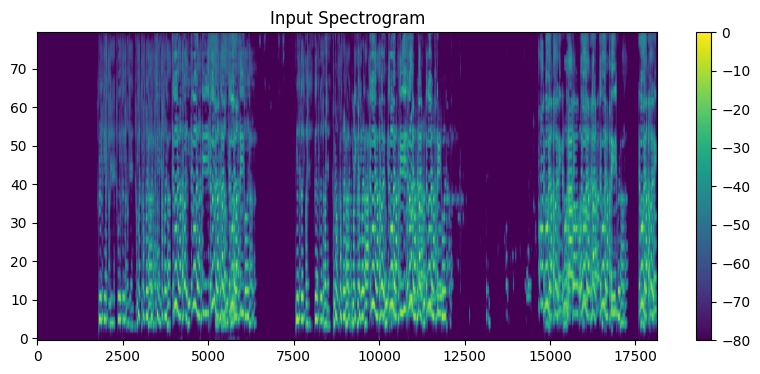

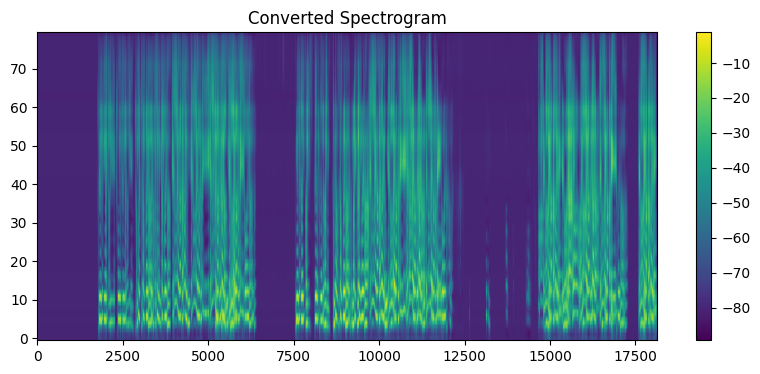

In [1]:
import torch
import numpy as np
import librosa
import os
from tqdm import tqdm
import torch.nn as nn
import soundfile as sf
import matplotlib.pyplot as plt

# Generator
class Generator(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=256, num_residual_blocks=6):
        super(Generator, self).__init__()
        layers = [
            nn.Conv1d(input_dim, hidden_dim, kernel_size=15, padding=7),
            nn.InstanceNorm1d(hidden_dim),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        for _ in range(2):
            layers.append(
                nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=5, stride=2, padding=2)
            )
            layers.append(nn.InstanceNorm1d(hidden_dim * 2))
            layers.append(nn.ReLU(inplace=True))
            hidden_dim *= 2

        # Residual blocks
        for _ in range(num_residual_blocks):
            layers.append(ResidualBlock(hidden_dim))

        # Upsampling
        for _ in range(2):
            layers.append(
                nn.ConvTranspose1d(hidden_dim, hidden_dim // 2, kernel_size=5, stride=2, padding=2, output_padding=1)
            )
            layers.append(nn.InstanceNorm1d(hidden_dim // 2))
            layers.append(nn.ReLU(inplace=True))
            hidden_dim //= 2

        layers.append(nn.Conv1d(hidden_dim, input_dim, kernel_size=15, padding=7))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm1d(dim),
            nn.ReLU(inplace=True),
            nn.Conv1d(dim, dim, kernel_size=3, padding=1),
            nn.InstanceNorm1d(dim)
        )

    def forward(self, x):
        return x + self.block(x)
        
# Utility function to pad or trim tensors to a consistent length
def pad_or_trim_tensor(tensor, target_length):
    # Handle 4D tensor from some spectrogram formats
    if tensor.ndim == 4:
        # Squeeze out unnecessary dimensions
        tensor = tensor.squeeze(0)

    # If tensor is already a PyTorch tensor, convert to NumPy if needed
    if isinstance(tensor, torch.Tensor):
        tensor = tensor.numpy()

    # Ensure tensor is of shape (80, time_steps)
    if tensor.ndim == 3:
        if tensor.shape[0] == 1:
            tensor = tensor.squeeze(0)
        elif tensor.shape[2] == 80:
            tensor = tensor.transpose(0, 2).squeeze(0)
    elif tensor.ndim == 2:
        # If shape is (time_steps, 80)
        if tensor.shape[1] == 80:
            tensor = tensor.T
    # Ensure shape is (80, time_steps)
    assert tensor.shape[0] == 80, f"Unexpected tensor shape: {tensor.shape}"

    current_length = tensor.shape[1]

    if current_length == target_length:
        return torch.from_numpy(tensor)

    if current_length < target_length:
        # Pad with zeros
        pad_size = target_length - current_length
        padded = np.pad(tensor, ((0, 0), (0, pad_size)), mode='constant')
        return torch.from_numpy(padded)
    else:
        # Trim 
        return torch.from_numpy(tensor[:, :target_length])

# Load the trained generator models
def load_model(model, model_path, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Convert spectrogram back to waveform
def spectrogram_to_audio(spectrogram, sr=16000, hop_length=256, win_length=1024):
    mel_spectrogram = librosa.db_to_amplitude(spectrogram)
    audio = librosa.feature.inverse.mel_to_audio(
        mel_spectrogram,
        sr=sr,
        n_fft=win_length,
        hop_length=hop_length,
        win_length=win_length
    )
    return audio

# Load spectrogram and process it
def load_and_process_spectrogram(file_path, target_length=None):
    spectrogram = np.load(file_path)
    if spectrogram.ndim == 4:
        spectrogram = spectrogram.squeeze(0)
    if spectrogram.ndim == 3:
        if spectrogram.shape[2] == 80:
            spectrogram = spectrogram.transpose(0, 2).squeeze(0)
    if spectrogram.ndim == 2 and spectrogram.shape[1] == 80:
        spectrogram = spectrogram.T
    assert spectrogram.shape[0] == 80, f"Unexpected spectrogram shape: {spectrogram.shape}"
    if target_length:
        current_length = spectrogram.shape[1]
        if current_length < target_length:
            spectrogram = np.pad(spectrogram, ((0, 0), (0, target_length - current_length)), mode='constant')
        else:
            spectrogram = spectrogram[:, :target_length]
    
    return torch.from_numpy(spectrogram).unsqueeze(0)

def convert_voice(generator, input_file, output_file, device, sr=16000, target_length=None):
    generator.eval()

    # Load input spectrogram
    input_spectrogram = np.load(input_file)
    print(f"Input spectrogram shape: {input_spectrogram.shape}")
    target_length = input_spectrogram.shape[1]
    # Preprocess input
    input_tensor = pad_or_trim_tensor(input_spectrogram, target_length).unsqueeze(0).to(device)

    # Generate converted spectrogram
    with torch.no_grad():
        converted_tensor = generator(input_tensor)

    # Convert tensor back to NumPy array
    converted_spectrogram = converted_tensor.squeeze(0).cpu().numpy()
    print(f"Converted spectrogram shape: {converted_spectrogram.shape}")
    print(f"Converted spectrogram values (sample): {converted_spectrogram[:5, :5]}")

    # Convert spectrogram to audio
    converted_audio = spectrogram_to_audio(converted_spectrogram, sr=sr)
    print(f"Audio signal shape: {converted_audio.shape}, Sampling rate: {sr}")

    # Save the audio file
    sf.write(output_file, converted_audio, sr)
    print(f"Converted audio saved to: {output_file}")

    
    plt.figure(figsize=(10, 4))
    plt.imshow(input_spectrogram, aspect='auto', origin='lower')
    plt.title("Input Spectrogram")
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.imshow(converted_spectrogram, aspect='auto', origin='lower')
    plt.title("Converted Spectrogram")
    plt.colorbar()
    plt.show()

# Paths to the models
G_A2B_path = "/kaggle/input/a2b-kishhore-in-arijit/pytorch/e1355-l139/1/G_A2B_epoch_1355.pth"
#G_B2A_path = "/kaggle/working/saved_models/G_B2A_epoch_50.pth"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models
G_A2B = Generator().to(device)
#G_B2A = Generator().to(device)

G_A2B = load_model(G_A2B, G_A2B_path, device)
#G_B2A = load_model(G_B2A, G_B2A_path, device)

# Convert voices
input_file = "/kaggle/input/fork-of-gan-song/specs/spec/arijit/song45-vocals.npy"  # Input spectrogram path
output_file = "/kaggle/working/arijit_to_kishore_epoch1242.wav"  # Output audio path

convert_voice(G_A2B, input_file, output_file, device)